In [19]:
import time

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

NUM_SAMPLES = 500
device = 'cpu:0'

# Force Float 64
tf.keras.backend.set_floatx('float64')


In [20]:
#Reação Não-elementar de duas etapas:
# A + B -> C
# B + C -> D

class Reactions(tf.keras.Model):
  
  def __init__(self, k1, k2, **kwargs):
    super().__init__(**kwargs)
    
    self.k1, self.k2 = k1, k2
  
  @tf.function
  def call(self, t, C):
    # C = [CA, CB, CC, CD]
    CA, CB, CC, CD = tf.unstack(C)
    
    r1 = k1 * CA * CB
    r2 = k2 * CB* CC
    
    dA_dt = -r1
    dB_dt = -r1 - r2
    dC_dt = r1 - r2
    dD_dt = r2
    
    return tf.stack([dA_dt, dB_dt, dC_dt, dD_dt])

In [21]:
t = tf.linspace(0., 5., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1, 0, 0], dtype=tf.float64)

k1 = 1
k2 = 1.5

In [22]:
with tf.device(device):
  result = odeint(Reactions(k1, k2), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (500, 4)


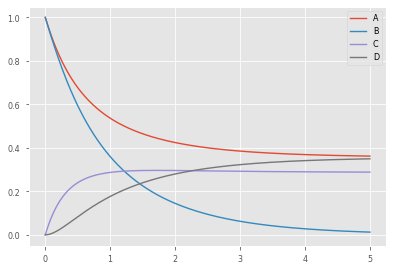

In [23]:
plot_results(t, result, labels=['A', 'B', 'C', 'D'])

In [24]:
class ReactionsTrainable(tf.keras.Model):
  
  def __init__(self, k1, k2, **kwargs):
    super().__init__(**kwargs)
    
    self.k1, self.k2 = k1, k2

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(4,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(4, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [A, B, C, D]
    A, B, C, D = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 4]))  # [1, 4] -> [1, 4]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    pred3 = n_out[0, 2]
    pred4 = n_out[0, 3]
    
    dA_dt = -self.k1*A*pred1        #pred1 = B
    dB_dt = -self.k1*A*B - pred2    #pred2 = self.k2*B*C
    dC_dt = pred3 - self.k2*B*C     #pred3 = self.k1*A*B
    dD_dt = self.k2*pred4           #pred4 = B*C
    
    
    return tf.stack([dA_dt, dB_dt, dC_dt, dD_dt])

In [25]:
t_train = tf.linspace(0., 3., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1, 0, 0], dtype=tf.float64)

k1 = 1
k2 = 1.5

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [26]:
from tensorflow.keras import backend as K
K.clear_session()

In [27]:
start = time.time()
with tf.device(device):
  model = ReactionsTrainable(k1, k2)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(Reactions(k1, k2), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()
end = time.time()
time_elapsed = end-start
print("Time elapsed: %f s" % time_elapsed)

Computing ground truth...
Ground truth shape : (30, 4)
Epoch 1
Loss : 0.09282839675043836
LR : 0.0099309245

Epoch 2
Loss : 0.086259372771906
LR : 0.009862327

Epoch 3
Loss : 0.08026565550364756
LR : 0.009794203

Epoch 4
Loss : 0.08204480949007838
LR : 0.0097265495

Epoch 5
Loss : 0.08221683588517267
LR : 0.009659363

Epoch 6
Loss : 0.08055368177787965
LR : 0.009592641

Epoch 7
Loss : 0.08018874570683707
LR : 0.009526379

Epoch 8
Loss : 0.08095214993720634
LR : 0.009460577

Epoch 9
Loss : 0.08107738469213104
LR : 0.009395227

Epoch 10
Loss : 0.08044499052118584
LR : 0.0093303295

Epoch 11
Loss : 0.0800416131099384
LR : 0.00926588

Epoch 12
Loss : 0.08021955883114748
LR : 0.009201876

Epoch 13
Loss : 0.08013184166147716
LR : 0.009138315

Epoch 14
Loss : 0.07604957406453444
LR : 0.009075192

Epoch 15
Loss : 0.07022239030703098
LR : 0.0090125045

Epoch 16
Loss : 0.06570071813724886
LR : 0.00895025

Epoch 17
Loss : 0.06475671730649579
LR : 0.008888427

Epoch 18
Loss : 0.06738260786378585
L

In [28]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [29]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [30]:
start = time.time()
model = bfgs_optimizer.minimize(loss_wrapper, model)
end = time.time()
time_elapsed = end - start
print("Time Elapsed: %f" % time_elapsed)

Iter: 1 loss: 0.00012620809370826781
Iter: 2 loss: 0.00012260188109279235
Iter: 3 loss: 0.0001536803091333545
Iter: 4 loss: 0.00012241125153348651
Iter: 5 loss: 0.00012199851718032434
Iter: 6 loss: 0.00011923087957640948
Iter: 7 loss: 0.00011884930431082154
Iter: 8 loss: 0.0001197971467000874
Iter: 9 loss: 0.00011868662149881768
Iter: 10 loss: 0.00011829788949014369
Iter: 11 loss: 0.00011754861366263912
Iter: 12 loss: 0.00013525525041473672
Iter: 13 loss: 0.00011754855417115803
Iter: 14 loss: 0.0001164468680478171
Iter: 15 loss: 0.00011240263506620959
Iter: 16 loss: 0.00010026981932552649
Iter: 17 loss: 0.00033111510405902853
Iter: 18 loss: 9.9671490904491565e-05
Iter: 19 loss: 9.9116650619183574e-05
Iter: 20 loss: 0.00010355617373851095
Iter: 21 loss: 9.9078647300021027e-05
Iter: 22 loss: 9.876455787107272e-05
Iter: 23 loss: 9.7654742153523746e-05
Iter: 24 loss: 9.56317635385842e-05
Iter: 25 loss: 9.5559642222124681e-05
Iter: 26 loss: 9.3581483063554771e-05
Iter: 27 loss: 0.0001074417

In [31]:
#Interpolating
t_eval = tf.linspace(0., 3, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(Reactions(k1, k2), initial_states, t_eval)

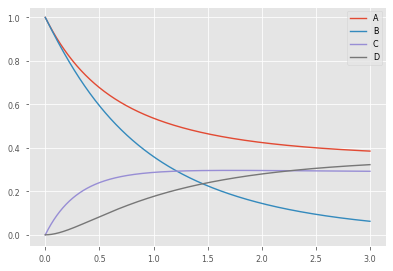

In [32]:
plot_results(t_eval, real_results, labels=['A', 'B', 'C', 'D'])


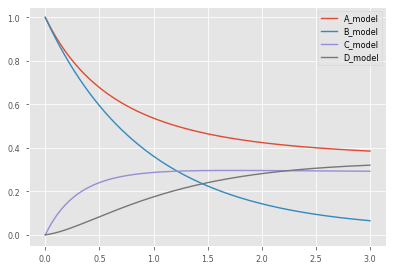

In [33]:
plot_results(t_eval, model_results, labels=['A_model', 'B_model', 'C_model', 'D_model'])

In [34]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [35]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

In [36]:
sindy_optm = SR3(threshold=0.1, nu=1, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

In [37]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=10, interaction_only=True),
      feature_names=['x0', 'x1', 'x2', 'x3'],
      optimizer=SR3(max_iter=100, nu=1))

In [38]:
sindy_model.print()

x0' = 136.321 1 + -609.863 x0 + 129.724 x1 + -254.914 x2 + -103.833 x3 + 342.797 x0 x1 + 1477.552 x0 x2 + 712.559 x0 x3 + -978.162 x1 x2 + -102.497 x1 x3 + -231.500 x2 x3 + -67.290 x0 x1 x2 + 413.740 x0 x1 x3 + -727.052 x0 x2 x3 + 34.306 x1 x2 x3 + 261.556 x0 x1 x2 x3
x1' = 34.484 1 + -111.442 x0 + 13.416 x1 + -73.422 x2 + -33.853 x3 + 62.467 x0 x1 + 255.636 x0 x2 + 119.479 x0 x3 + -121.390 x1 x2 + -16.902 x1 x3 + -13.975 x2 x3 + -36.245 x0 x1 x2 + 57.994 x0 x1 x3 + -40.006 x0 x2 x3 + -15.023 x1 x2 x3 + 18.369 x0 x1 x2 x3
x2' = -288.273 1 + 1364.620 x0 + -322.558 x1 + 521.838 x2 + 186.135 x3 + -752.764 x0 x1 + -3336.828 x0 x2 + -1595.472 x0 x3 + 2297.809 x1 x2 + 227.111 x1 x3 + 652.135 x2 x3 + 118.873 x0 x1 x2 + -902.629 x0 x1 x3 + 1714.980 x0 x2 x3 + -102.109 x1 x2 x3 + -611.373 x0 x1 x2 x3
x3' = 71.869 1 + -336.525 x0 + 60.538 x1 + -130.432 x2 + -62.298 x3 + 204.180 x0 x1 + 813.693 x0 x2 + 397.039 x0 x3 + -540.417 x1 x2 + -55.871 x1 x3 + -98.227 x2 x3 + -28.382 x0 x1 x2 + 263.594 x0 

In [39]:
sindy_model.coefficients()

array([[  136.32142521,  -609.86255049,   129.72372745,  -254.91436885,
         -103.83291564,   342.79651269,  1477.5517835 ,   712.5594984 ,
         -978.16187371,  -102.49692098,  -231.49984976,   -67.28991509,
          413.74033953,  -727.0518175 ,    34.30571414,   261.55628799],
       [   34.48361632,  -111.44183407,    13.41588464,   -73.42181932,
          -33.85327812,    62.46670897,   255.63597821,   119.47944086,
         -121.38999723,   -16.90217092,   -13.97541462,   -36.24488756,
           57.99388427,   -40.00615862,   -15.0228047 ,    18.36915905],
       [ -288.27335703,  1364.6196737 ,  -322.55777075,   521.83812764,
          186.1350847 ,  -752.76370487, -3336.82815357, -1595.47225945,
         2297.8088716 ,   227.11132956,   652.13516996,   118.87318413,
         -902.62885574,  1714.97992992,  -102.10946795,  -611.3732018 ],
       [   71.86936573,  -336.52528242,    60.53752392,  -130.43157859,
          -62.29795484,   204.17962189,   813.69272618,   397

In [40]:
sindy_model.score(model_preds_np, t_eval_np)

0.9999999999888916